# Season-Influence-on-My-Listening-Habit
This project explores the effect of seasons on my music preferences by integrating data from Spotify, AccuWeather, and Genius API.

## Project Overview
The aim is to analyze how weather and seasons influence my music choices, including genres, tempos, and moods. 

## Dataset
- **Spotify Listening History**: Track name, artist, timestamp.
- **Weather Data**: Daily weather metrics such as temperature, precipitation, and cloudiness.
- **Sentiment Analysis**: Extract emotional tone from song lyrics.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


## Data Loading and Preprocessing

In [2]:
import pandas as pd

# Load weather data
weather_data = pd.read_csv('istanbul_weather_2023_2024.csv')
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Load Spotify streaming history
spotify_data = pd.read_json('Streaming_History_Audio_2023-2024_1.json')
spotify_data['Date'] = pd.to_datetime(spotify_data['ts']).dt.date
spotify_data['Date'] = pd.to_datetime(spotify_data['Date'])  # Ensure the Date column is of datetime type

# Merge on the Date column
merged_data = pd.merge(spotify_data, weather_data, on='Date', how='inner')

# Display the first few rows of the merged dataset
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ts                                 19530 non-null  object        
 1   platform                           19530 non-null  object        
 2   ms_played                          19530 non-null  int64         
 3   conn_country                       19530 non-null  object        
 4   ip_addr                            19530 non-null  object        
 5   master_metadata_track_name         19523 non-null  object        
 6   master_metadata_album_artist_name  19523 non-null  object        
 7   master_metadata_album_album_name   19523 non-null  object        
 8   spotify_track_uri                  19523 non-null  object        
 9   episode_name                       7 non-null      object        
 10  episode_show_name                 

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# ---------------------------------------
# 1. Spotify API Authentication
# ---------------------------------------
client_id = 'your_client_id'
client_secret = 'your_client_secret'
callback_url = 'your_callback_url'

access_scope = "user-library-read"

spotify_api = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=client_id,
        client_secret=client_secret,
        redirect_uri=callback_url,
        scope=access_scope
    )
)

# ---------------------------------------
# 2. Utility: Split Sequence into Chunks
# ---------------------------------------
def partition_list(items, chunk_size=50):
    """
    Split 'items' into chunks of size 'chunk_size'.
    """
    for i in range(0, len(items), chunk_size):
        yield items[i : i + chunk_size]

# ---------------------------------------
# 3. Extract Track IDs from DataFrame
# ---------------------------------------
# 'merged_data' should be your DataFrame with a 'spotify_uri' column.
unique_uris = merged_data['spotify_track_uri'].dropna().unique()

# Extract track IDs from Spotify URIs.
track_ids = [uri.split(':')[-1] for uri in unique_uris if uri.startswith('spotify:track:')]

# ---------------------------------------
# 4. Fetch Track Details in Batches
# ---------------------------------------
track_metadata = []  # To store track details
for batch in partition_list(track_ids, 50):
    response = spotify_api.tracks(batch)  # Max 50 track IDs per request
    if response and 'tracks' in response:
        track_metadata.extend(response['tracks'])

# ---------------------------------------
# 5. Collect Unique Artist IDs
# ---------------------------------------
artist_ids = set()
for track in track_metadata:
    if track and 'artists' in track:
        for artist in track['artists']:
            artist_ids.add(artist['id'])

# ---------------------------------------
# 6. Retrieve Artist Details in Batches
# ---------------------------------------
artist_details = []
artist_id_list = list(artist_ids)
for batch in partition_list(artist_id_list, 50):
    artist_response = spotify_api.artists(batch)  # Max 50 artist IDs per request
    if artist_response and 'artists' in artist_response:
        artist_details.extend(artist_response['artists'])

# Create a dictionary mapping artist IDs to their genres
artist_genre_map = {artist['id']: artist.get('genres', []) for artist in artist_details}

# ---------------------------------------
# 7. Create DataFrame with Track Genres
# ---------------------------------------
track_info_list = []
for track in track_metadata:
    if not track:
        continue
    track_id = track.get('id')
    track_name = track.get('name', 'Unknown')
    main_artist_id = track['artists'][0]['id'] if track.get('artists') else None
    genre_list = artist_genre_map.get(main_artist_id, [])
    track_info_list.append({
        'track_id': track_id,
        'track_name': track_name,
        'artist_id': main_artist_id,
        'genres': ', '.join(genre_list)
    })

track_genres_df = pd.DataFrame(track_info_list)

# ---------------------------------------
# 8. Merge Genre Info Back to Original Data
# ---------------------------------------
# Extract 'track_id' from 'spotify_uri' in merged_data
merged_data['track_id'] = merged_data['spotify_track_uri'].str.split(':').str[-1]

final_data = pd.merge(
    merged_data,
    track_genres_df,
    how='left',
    on='track_id'
)

final_data.head()


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,Date,Temperature (C),Weather Condition,Precipitation (mm),Humidity (%),Wind Speed (km/h),track_id,track_name,artist_id,genres
0,2023-05-29T18:56:22Z,ios,152187,TR,188.57.94.134,RANDEVU,Motive,RANDEVU,spotify:track:4dNXz1K0QBtcIoeoqnJw0m,None,...,2023-05-29,22,Sunny,0.0,67,19,4dNXz1K0QBtcIoeoqnJw0m,RANDEVU,6sBSLIunx1Je0Y2T77wpkP,"turkish hip hop, turkish trap"
1,2023-05-29T18:58:27Z,ios,124392,TR,188.57.94.134,FRISBEE,Alaylı,FRISBEE,spotify:track:59pB0FRlPeXXOIJCpqF64h,None,...,2023-05-29,22,Sunny,0.0,67,19,59pB0FRlPeXXOIJCpqF64h,FRISBEE,35Y43Jjo8IufuIaap1GDkL,
2,2023-05-29T19:01:27Z,ios,180666,TR,188.57.94.134,Milyon Dolarlık Bebek,Bixi Blake,Anka: The Return Of The Phoenix,spotify:track:3mnAg1mO9ZuINc8Udmtavu,None,...,2023-05-29,22,Sunny,0.0,67,19,3mnAg1mO9ZuINc8Udmtavu,Milyon Dolarlık Bebek,2NPl6xmez0ma3ssIrMz1DM,"turkish hip hop, turkish trap"
3,2023-05-29T19:04:54Z,ios,205500,TR,188.57.94.134,LOCO,Critical,LOCO,spotify:track:6aerOZdzEU7bzf2D2JBIv5,None,...,2023-05-29,22,Sunny,0.0,67,19,6aerOZdzEU7bzf2D2JBIv5,LOCO,6dOAGo4z0syiCjbnlh4VSO,"new school turkce rap, turkce drill, turkish h..."
4,2023-05-29T19:10:22Z,ios,125185,TR,188.57.94.134,Matmazel,Tanerman,Orkestra,spotify:track:4jUJaEOJBMEE5BgGnki85y,None,...,2023-05-29,22,Sunny,0.0,67,19,4jUJaEOJBMEE5BgGnki85y,Matmazel,1X8IDE7vOMFmhR8Hg32EGA,new school turkce rap


In [4]:
final_data['genre'] = final_data['genres'].apply(
    lambda x: x.split(',')[0].strip() if isinstance(x, str) and x else 'Unknown'
)

final_data.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,Temperature (C),Weather Condition,Precipitation (mm),Humidity (%),Wind Speed (km/h),track_id,track_name,artist_id,genres,genre
0,2023-05-29T18:56:22Z,ios,152187,TR,188.57.94.134,RANDEVU,Motive,RANDEVU,spotify:track:4dNXz1K0QBtcIoeoqnJw0m,None,...,22,Sunny,0.0,67,19,4dNXz1K0QBtcIoeoqnJw0m,RANDEVU,6sBSLIunx1Je0Y2T77wpkP,"turkish hip hop, turkish trap",turkish hip hop
1,2023-05-29T18:58:27Z,ios,124392,TR,188.57.94.134,FRISBEE,Alaylı,FRISBEE,spotify:track:59pB0FRlPeXXOIJCpqF64h,None,...,22,Sunny,0.0,67,19,59pB0FRlPeXXOIJCpqF64h,FRISBEE,35Y43Jjo8IufuIaap1GDkL,,Unknown
2,2023-05-29T19:01:27Z,ios,180666,TR,188.57.94.134,Milyon Dolarlık Bebek,Bixi Blake,Anka: The Return Of The Phoenix,spotify:track:3mnAg1mO9ZuINc8Udmtavu,None,...,22,Sunny,0.0,67,19,3mnAg1mO9ZuINc8Udmtavu,Milyon Dolarlık Bebek,2NPl6xmez0ma3ssIrMz1DM,"turkish hip hop, turkish trap",turkish hip hop
3,2023-05-29T19:04:54Z,ios,205500,TR,188.57.94.134,LOCO,Critical,LOCO,spotify:track:6aerOZdzEU7bzf2D2JBIv5,None,...,22,Sunny,0.0,67,19,6aerOZdzEU7bzf2D2JBIv5,LOCO,6dOAGo4z0syiCjbnlh4VSO,"new school turkce rap, turkce drill, turkish h...",new school turkce rap
4,2023-05-29T19:10:22Z,ios,125185,TR,188.57.94.134,Matmazel,Tanerman,Orkestra,spotify:track:4jUJaEOJBMEE5BgGnki85y,None,...,22,Sunny,0.0,67,19,4jUJaEOJBMEE5BgGnki85y,Matmazel,1X8IDE7vOMFmhR8Hg32EGA,new school turkce rap,new school turkce rap


In [10]:
def assign_season(date):
    """
    Assign season based on the date.
    """
    month = date.month
    day = date.day
    
    # Winter
    if (month == 12 and day >= 21) or (month <= 3 and (month < 3 or day <= 20)):
        return 'Winter'
    # Spring
    elif (month == 3 and day >= 21) or (3 < month < 6) or (month == 6 and day <= 20):
        return 'Spring'
    # Summer
    elif (month == 6 and day >= 21) or (6 < month < 9) or (month == 9 and day <= 22):
        return 'Summer'
    # Autumn
    else:
        return 'Autumn'

# Add Season column to merged data
final_data['Season'] = final_data['Date'].apply(lambda x: assign_season(pd.to_datetime(x)))

# Display the updated data
print(final_data.head())


                     ts platform  ms_played conn_country        ip_addr  \
0  2023-05-29T18:56:22Z      ios     152187           TR  188.57.94.134   
2  2023-05-29T19:01:27Z      ios     180666           TR  188.57.94.134   
3  2023-05-29T19:04:54Z      ios     205500           TR  188.57.94.134   
4  2023-05-29T19:10:22Z      ios     125185           TR  188.57.94.134   
5  2023-05-29T19:13:37Z      ios     194586           TR  188.57.94.134   

  master_metadata_track_name master_metadata_album_artist_name  \
0                    RANDEVU                            Motive   
2      Milyon Dolarlık Bebek                        Bixi Blake   
3                       LOCO                          Critical   
4                   Matmazel                          Tanerman   
5                       Goal                            Patron   

  master_metadata_album_album_name                     spotify_track_uri  \
0                          RANDEVU  spotify:track:4dNXz1K0QBtcIoeoqnJw0m   


In [11]:
# Delete rows where the 'genre' column has the value 'Unknown'
final_data = final_data[final_data['genre'] != 'Unknown']

# Display the updated data
final_data.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,Precipitation (mm),Humidity (%),Wind Speed (km/h),track_id,track_name,artist_id,genres,genre,Number of Songs Played,Season
0,2023-05-29T18:56:22Z,ios,152187,TR,188.57.94.134,RANDEVU,Motive,RANDEVU,spotify:track:4dNXz1K0QBtcIoeoqnJw0m,None,...,0.0,67,19,4dNXz1K0QBtcIoeoqnJw0m,RANDEVU,6sBSLIunx1Je0Y2T77wpkP,"turkish hip hop, turkish trap",turkish hip hop,0.845483,Spring
2,2023-05-29T19:01:27Z,ios,180666,TR,188.57.94.134,Milyon Dolarlık Bebek,Bixi Blake,Anka: The Return Of The Phoenix,spotify:track:3mnAg1mO9ZuINc8Udmtavu,None,...,0.0,67,19,3mnAg1mO9ZuINc8Udmtavu,Milyon Dolarlık Bebek,2NPl6xmez0ma3ssIrMz1DM,"turkish hip hop, turkish trap",turkish hip hop,1.003700,Spring
3,2023-05-29T19:04:54Z,ios,205500,TR,188.57.94.134,LOCO,Critical,LOCO,spotify:track:6aerOZdzEU7bzf2D2JBIv5,None,...,0.0,67,19,6aerOZdzEU7bzf2D2JBIv5,LOCO,6dOAGo4z0syiCjbnlh4VSO,"new school turkce rap, turkce drill, turkish h...",new school turkce rap,1.141667,Spring
4,2023-05-29T19:10:22Z,ios,125185,TR,188.57.94.134,Matmazel,Tanerman,Orkestra,spotify:track:4jUJaEOJBMEE5BgGnki85y,None,...,0.0,67,19,4jUJaEOJBMEE5BgGnki85y,Matmazel,1X8IDE7vOMFmhR8Hg32EGA,new school turkce rap,new school turkce rap,0.695472,Spring
5,2023-05-29T19:13:37Z,ios,194586,TR,188.57.94.134,Goal,Patron,Goal,spotify:track:4QVEEOx7TeTA0vQfeP8tgN,None,...,0.0,67,19,4QVEEOx7TeTA0vQfeP8tgN,Goal,2r8iLFeSTuOiZualHmSXxS,"turkish hip hop, turkish trap",turkish hip hop,1.081033,Spring


## Exploratory Data Analysis (EDA)

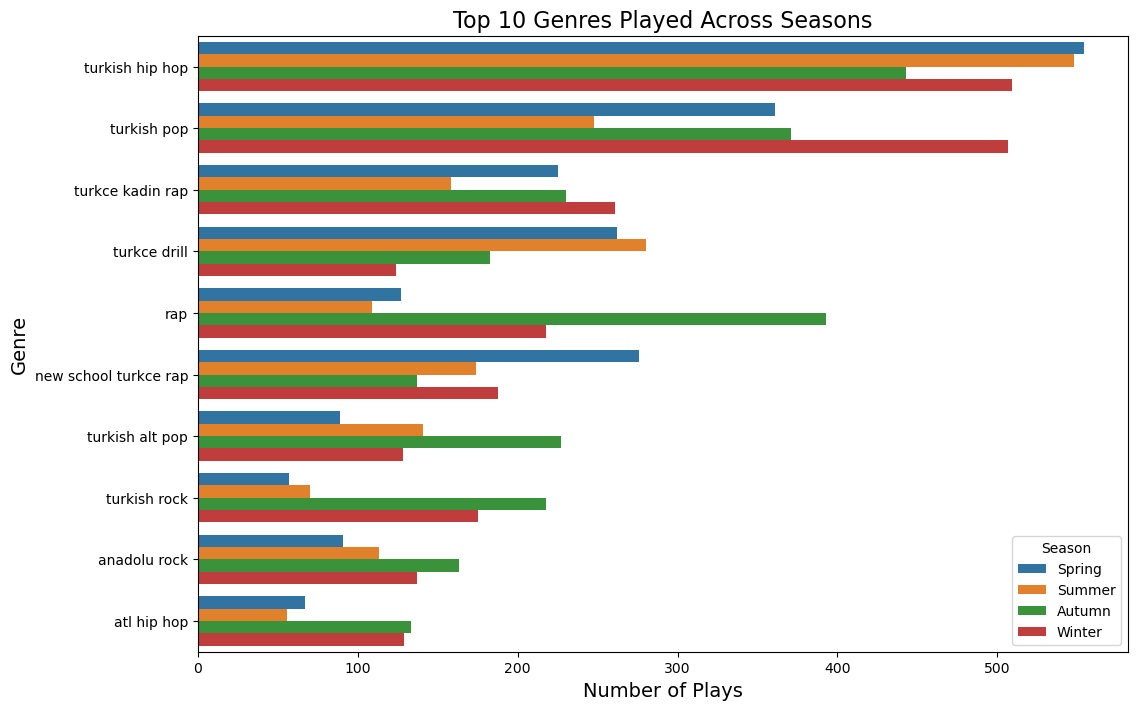

In [12]:
# Delete rows where the 'genre' column has the value 'Unknown'
final_data = final_data[final_data['genre'] != 'Unknown']

# Plot the top 10 genres played across seasons
plt.figure(figsize=(12, 8))
sns.countplot(data=final_data, y='genre', hue='Season', order=final_data['genre'].value_counts().index[:10])
plt.title('Top 10 Genres Played Across Seasons', fontsize=16)
plt.xlabel('Number of Plays', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.legend(title='Season')
plt.show()


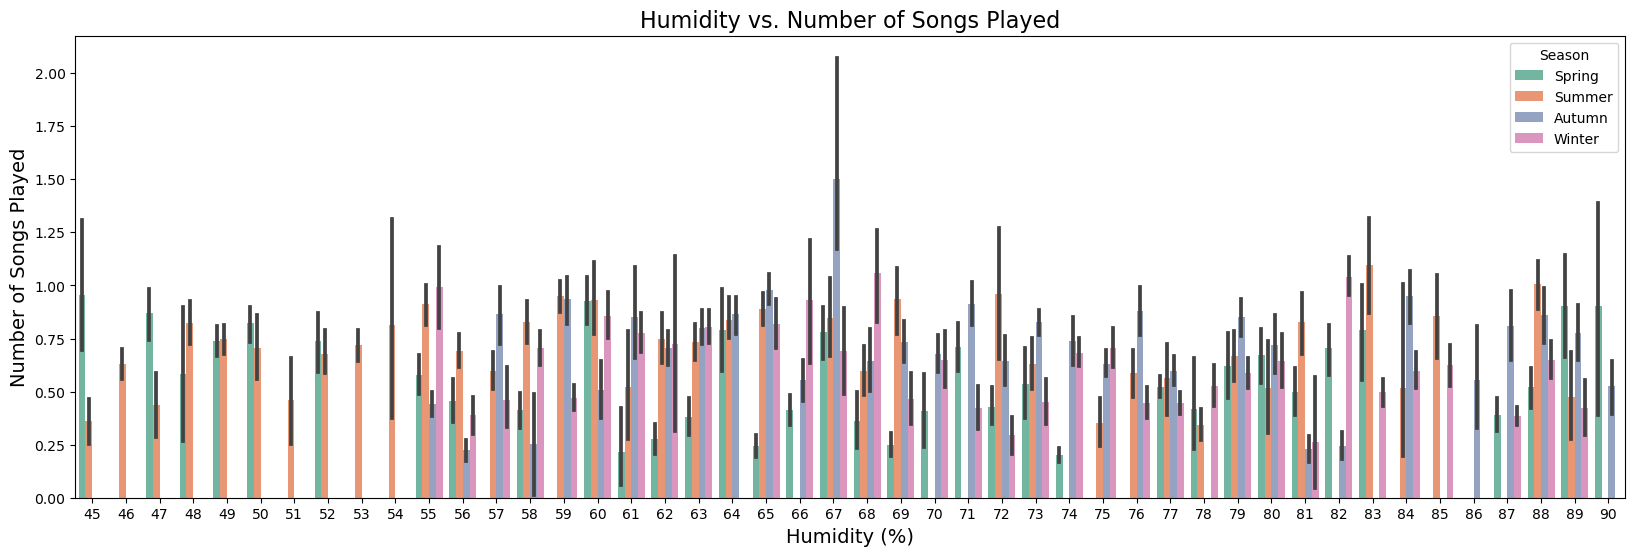

In [13]:
plt.figure(figsize=(20, 6))
# Assuming an average song length of 3 minutes (180000 milliseconds)
final_data.loc[:, 'Number of Songs Played'] = final_data['ms_played'] / 180000
sns.barplot(data=final_data, x='Humidity (%)', y='Number of Songs Played', hue='Season', palette='Set2')
plt.title('Humidity vs. Number of Songs Played', fontsize=16)
plt.xlabel('Humidity (%)', fontsize=14)
plt.ylabel('Number of Songs Played', fontsize=14)
plt.legend(title='Season')
plt.show()


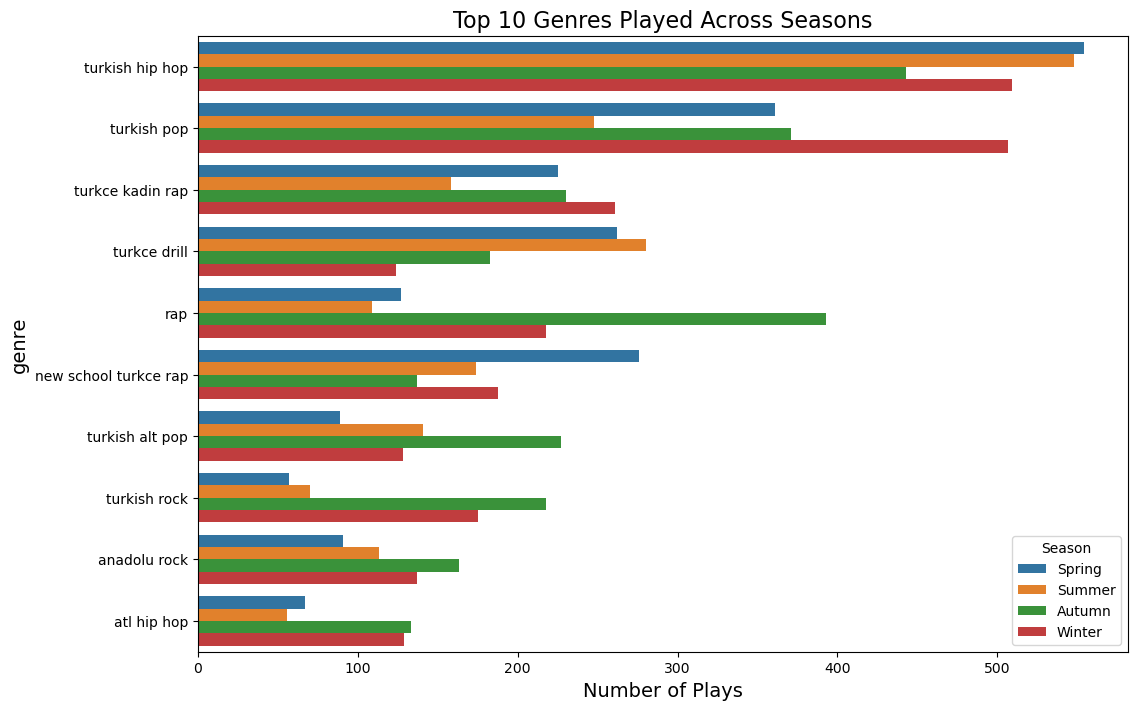

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(data=final_data, y='genre', hue='Season', order=final_data['genre'].value_counts().index[:10])
plt.title('Top 10 Genres Played Across Seasons', fontsize=16)
plt.xlabel('Number of Plays', fontsize=14)
plt.ylabel('genre', fontsize=14)
plt.legend(title='Season')
plt.show()


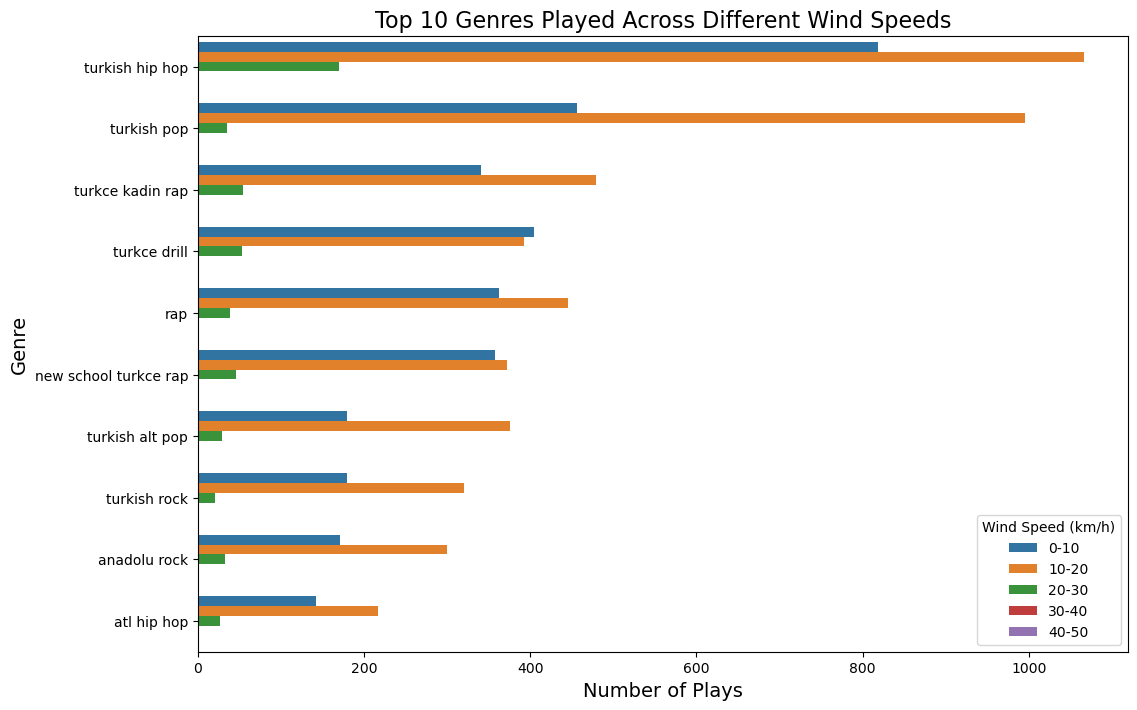

In [15]:
# Create a new column for wind speed categories
final_data['Wind Speed Category'] = pd.cut(final_data['Wind Speed (km/h)'], bins=[0, 10, 20, 30, 40, 50], labels=['0-10', '10-20', '20-30', '30-40', '40-50'])

plt.figure(figsize=(12, 8))
sns.countplot(data=final_data, y='genre', hue='Wind Speed Category', order=final_data['genre'].value_counts().index[:10])
plt.title('Top 10 Genres Played Across Different Wind Speeds', fontsize=16)
plt.xlabel('Number of Plays', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.legend(title='Wind Speed (km/h)')
plt.show()


## Machine Learning Model

In [16]:
final_data.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode', 'Date', 'Temperature (C)', 'Weather Condition',
       'Precipitation (mm)', 'Humidity (%)', 'Wind Speed (km/h)', 'track_id',
       'track_name', 'artist_id', 'genres', 'genre', 'Number of Songs Played',
       'Season', 'Wind Speed Category'],
      dtype='object')

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

ctg = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Autumn': 3
}

# Prepare data for machine learning
X = final_data[['Temperature (C)', 'Humidity (%)','Wind Speed (km/h)']]
y = final_data['genre']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

                                         precision    recall  f1-score   support

                            acid techno       1.00      0.00      0.00         1
                           acoustic pop       1.00      0.00      0.00         8
                        adult standards       1.00      0.00      0.00        16
                             afro house       0.00      1.00      0.00         0
                           afrofuturism       1.00      0.00      0.00         8
                             album rock       0.10      0.02      0.03        58
                                  alt z       1.00      0.00      0.00         2
                      alternative dance       1.00      0.00      0.00         6
                      alternative metal       0.00      0.00      0.00        52
                       alternative rock       1.00      0.00      0.00        27
                          ambient house       1.00      0.00      0.00         2
                           

KNN Classification Report:
                                         precision    recall  f1-score   support

                            acid techno       0.00      0.00      0.00         1
                           acoustic pop       0.00      0.00      0.00         8
                        adult standards       0.00      0.00      0.00        16
                           afrofuturism       0.00      0.00      0.00         8
                             album rock       0.01      0.07      0.02        58
                                  alt z       0.00      0.00      0.00         2
                      alternative dance       0.00      0.00      0.00         6
                      alternative metal       0.03      0.10      0.05        52
                       alternative rock       0.02      0.04      0.02        27
                          ambient house       0.00      0.00      0.00         2
                            ambient pop       0.00      0.00      0.00         1


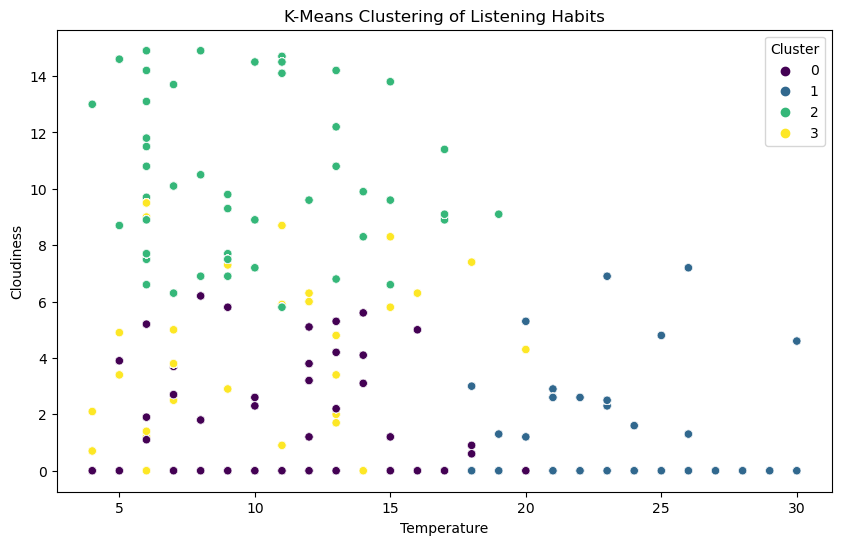

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Select features for KNN and K-Means
features = ['Temperature (C)', 'Precipitation (mm)', 'Wind Speed (km/h)']
X = final_data[features]
y = final_data['genre']  # Assuming Genre_Label is the target for classification

# Standardize features for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
knn_predictions = knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, knn_predictions):.2f}")

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Assuming 4 clusters for seasons
kmeans.fit(X_scaled)
final_data['Cluster'] = kmeans.labels_

# Visualize K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_data['Temperature (C)'], y=final_data['Precipitation (mm)'], hue=final_data['Cluster'], palette='viridis')
plt.title('K-Means Clustering of Listening Habits')
plt.xlabel('Temperature')
plt.ylabel('Cloudiness')
plt.legend(title='Cluster')
plt.show()
